In [1]:
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GaussianNoise


2024-10-29 23:10:26.252402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 23:10:26.326904: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 23:10:26.349267: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 23:10:26.493625: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-29 23:10:27.753865: W tensorflow/compiler/tf2

# Tratamento dos dados

Começamos o projeto fazendo a leitura dos arquivos e estocagem adequada em diferentes vetores

In [2]:
datadir = "data"

X_raw = []
Y = []
X_test_raw = []
Y_test = []

# control
files = os.listdir(os.path.join(datadir, "ctrl"))
files.sort()
for file in files:
    path = os.path.join(datadir, "ctrl", file)
    df = pl.read_csv(path, has_header=False, columns=[0], separator=";")
    X_raw.append(np.reshape(df.to_numpy(), (-1,)))
    Y.append(np.array([1.0, 0.0]))

# positive
files = os.listdir(os.path.join(datadir, "pt"))
files.sort()
for file in files:
    path = os.path.join(datadir, "pt", file)
    df = pl.read_csv(path, has_header=False, columns=[0], separator=";")
    X_raw.append(np.reshape(df.to_numpy(), (-1,)))
    Y.append(np.array([0.0, 1.0]))

# validation
files = os.listdir(os.path.join(datadir, "v"))
files.sort()
for file in files:
    path = os.path.join(datadir, "v", file)
    df = pl.read_csv(path, has_header=False, columns=[0], separator=";")
    X_test_raw.append(np.reshape(df.to_numpy(), (-1,)))
    Y_test.append(np.array([0.0, 1.0]) if 'd' in file else np.array([1.0, 0.0]))

assert len(X_raw) == len(Y)
assert len(X_test_raw) == len(Y_test)
assert len(X_raw[0]) == len(X_test_raw[0])
assert len(Y[0]) == len(Y_test[0])

print("Training samples:", len(X_raw))
print("Testing samples: ", len(X_test_raw))


Training samples: 57
Testing samples:  6


In [3]:
sample_freq = 2000      # Hz
sample_period = 1/2000  # s
signal_length = len(X_raw[0]) * sample_period


[1. 0.]


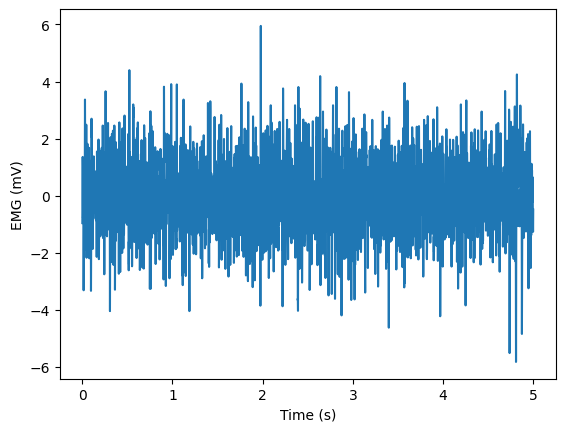

[0. 1.]


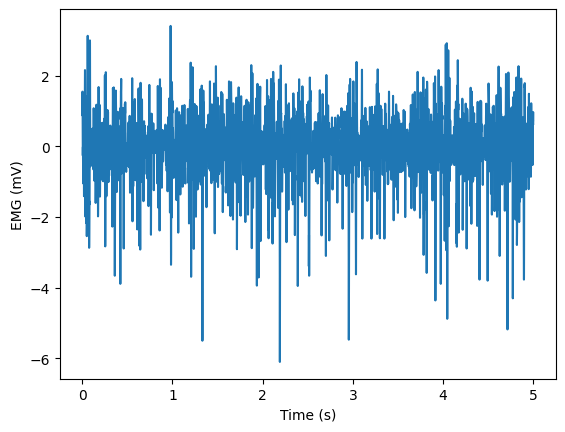

In [4]:
print(Y[0])
plt.plot(np.linspace(0, sample_period * len(X_raw[0]), len(X_raw[0])), 1e3 * X_raw[0])
plt.xlabel("Time (s)")
plt.ylabel("EMG (mV)")
plt.show()

print(Y[-1])
plt.plot(np.linspace(0, sample_period * len(X_raw[-1]), len(X_raw[-1])), 1e3 * X_raw[-1])
plt.xlabel("Time (s)")
plt.ylabel("EMG (mV)")
plt.show()


# Espectograma

A primeira análise que faremos será através de uma Rede Neural Convolucional (CNN), tomando por entrada o espectograma do sinal

In [8]:
def to_spectogram(x):
    # Configuration parameters
    nfft = 1024
    noverlap = 512 + 256 + 128
    window = np.hanning(nfft)  # Hanning window function

    # Calculate the step size based on the overlap
    step = nfft - noverlap

    # Pad the signal to handle the windowing properly
    pad_width = (step - (len(x) - noverlap) % step) % step
    padded_signal = np.pad(x, (0, pad_width), mode='constant')

    # Generate the segments using stride tricks
    segments = np.lib.stride_tricks.sliding_window_view(padded_signal, nfft)[::step]

    # Apply the window function to each segment
    windowed_segments = segments * window

    # Compute the Fourier Transform and get the magnitude squared (power spectrogram)
    Zxx = np.abs(np.fft.rfft(windowed_segments, axis=1))**2

    # Scale to match the matplotlib output
    Sxx = (Zxx / (window.sum()**2)).T

    # Frequencies and time bins
    freqs = np.fft.rfftfreq(nfft, d=1/sample_freq)
    times = np.arange(segments.shape[0]) * step / sample_freq

    return Sxx


In [9]:
X_spec = [to_spectogram(x) for x in X_raw]
X_test_spec = [to_spectogram(x) for x in X_test_raw]

X_spec[0]

array([[2.58049852e-16, 2.03250227e-14, 1.97767905e-15, ...,
        1.05529818e-14, 1.87630624e-14, 2.02132318e-13],
       [2.79003204e-15, 8.42206260e-15, 6.11263626e-15, ...,
        1.61800423e-14, 1.64086921e-14, 4.69553406e-13],
       [3.30216720e-15, 5.48288795e-15, 6.10595506e-16, ...,
        2.80599376e-17, 2.40813301e-15, 2.55087726e-13],
       ...,
       [8.24550294e-15, 9.18474442e-15, 6.99800760e-15, ...,
        2.07155196e-15, 7.75383564e-16, 5.35461238e-15],
       [5.78096207e-15, 3.38281369e-15, 1.02701632e-15, ...,
        4.02389229e-15, 1.24974507e-15, 8.21432172e-16],
       [5.35231285e-15, 4.00674338e-15, 8.46812561e-16, ...,
        2.11743557e-15, 2.05253418e-16, 2.47716884e-15]])

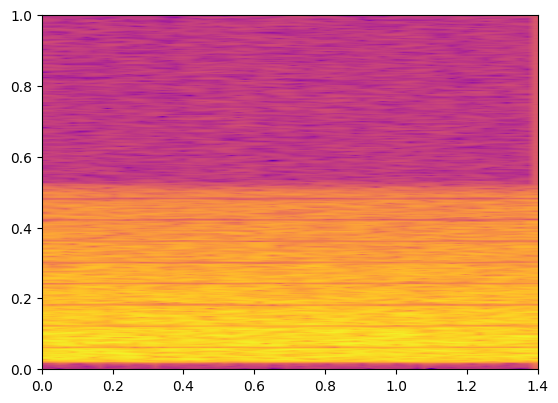

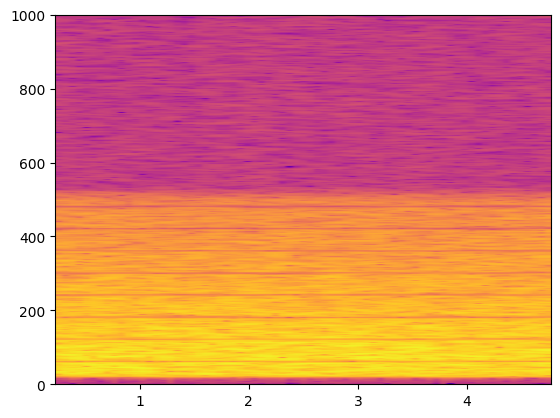

In [11]:
# Reshape the data to add the channel dimension (batch_size, height, width, channels)
X = np.log(np.array(X_spec).reshape(-1, 513, 72, 1))
Y = np.array(Y)
X_test = np.log(np.array(X_test_spec).reshape(-1, 513, 72, 1))
Y_test = np.array(Y_test)

plt.imshow(X[5,:,:,0], cmap='plasma', interpolation='bilinear', origin='lower', extent=[0, 1.4, 0, 1])
plt.show()

plt.specgram(X_raw[5], NFFT=1024, Fs=sample_freq, noverlap=1024-128, cmap='plasma')
plt.show()


The image above was generated as a comparison reference, to ensure the reshape is working as expected

In [26]:
# Define the CNN model
model = Sequential([
    Input((513, 72, 1)),
    Conv2D(4, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(2, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(4, activation='gelu'),
    Dense(4, activation='gelu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Output layer with softmax for probability output
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X, Y, epochs=128, batch_size=16, validation_data=(X_test, Y_test), verbose=2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/128
4/4 - 3s - 827ms/step - accuracy: 0.4561 - loss: 0.7302 - val_accuracy: 0.5000 - val_loss: 0.7017
Epoch 2/128
4/4 - 0s - 22ms/step - accuracy: 0.4912 - loss: 0.7142 - val_accuracy: 0.5000 - val_loss: 0.6971
Epoch 3/128
4/4 - 0s - 23ms/step - accuracy: 0.4561 - loss: 0.7043 - val_accuracy: 0.5000 - val_loss: 0.6906
Epoch 4/128
4/4 - 0s - 21ms/step - accuracy: 0.4912 - loss: 0.6840 - val_accuracy: 0.5000 - val_loss: 0.6891
Epoch 5/128
4/4 - 0s - 21ms/step - accuracy: 0.5614 - loss: 0.6890 - val_accuracy: 0.6667 - val_loss: 0.6888
Epoch 6/128
4/4 - 0s - 21ms/step - accuracy: 0.6667 - loss: 0.6703 - val_accuracy: 0.5000 - val_loss: 0.6898
Epoch 7/128
4/4 - 0s - 21ms/step - accuracy: 0.4561 - loss: 0.6942 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 8/128
4/4 - 0s - 20ms/step - accuracy: 0.5614 - loss: 0.6848 - val_accuracy: 0.5000 - val_loss: 0.6892
Epoch 9/128
4/4 - 0s - 15ms/step - accuracy: 0.5614 - loss: 0.6781 - val_accuracy: 0.6667 - val_loss: 0.6816
Epoch 10/128
4/4 -

In [28]:
loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Train Loss: 0.10474731773138046
Train Accuracy: 100.00%

Test Loss: 0.24411244690418243
Test Accuracy: 100.00%


O exemplo acima requeriu ser executado algumas vezes até que convergisse numa solução decente. Com esta solução, conseguimos classificar com 100% de acurácia os sinais.

# Média móvel

O segundo método que utilisaremos será através de uma média móvel para remover parte do ruído do sinal. Dado que o que imaginamos que esteja acontecendo é a força do sinal estar decaindo mais rápido no tempo para pacientes com diabetes, a média móvel nos permitirá fazer uma melhor análise da amplitude do sinal.

In [29]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


In [30]:
X_amp = np.array([moving_average(x, 20) for x in X_raw])
X_test_amp = np.array([moving_average(x, 20) for x in X_test_raw])

X_amp.shape


(57, 9982)

In [31]:
sample_count = len(X_amp[0])
X = np.array(X_amp).reshape(-1, sample_count)
Y = np.array(Y)
X_test = np.array(X_test_amp).reshape(-1, sample_count)
Y_test = np.array(Y_test)

(X.shape, Y.shape, X_test.shape, Y_test.shape)


((57, 9982), (57, 2), (6, 9982), (6, 2))

In [32]:
# Define the CNN model
model = Sequential([
    Input((sample_count,)),
    Dropout(0.99),
    GaussianNoise(1e-5),
    # Dense(1, activation='gelu'),
    # Dense(2, activation='gelu'),
    Dense(2, activation='softmax')  # Output layer with softmax for probability output
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['binary_accuracy', 'Precision', 'F1Score', 'Recall'])
model.fit(X, Y, epochs=100, batch_size=16, validation_data=(X_test, Y_test), verbose=2)

loss, accuracy, prec, f1, recall = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
print(f"Train Precision: {prec}")
print(f"Train Recall: {recall}")
print(f"Train F1Score: {f1}")
loss, accuracy, prec, f1, recall = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {prec}")
print(f"Test Recall: {recall}")
print(f"Test F1Score: {f1}")


Epoch 1/100
4/4 - 4s - 1s/step - F1Score: 0.4500 - Precision: 0.4561 - Recall: 0.4561 - binary_accuracy: 0.4561 - loss: 0.6932 - val_F1Score: 0.3333 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_binary_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/100
4/4 - 0s - 15ms/step - F1Score: 0.5426 - Precision: 0.5439 - Recall: 0.5439 - binary_accuracy: 0.5439 - loss: 0.6919 - val_F1Score: 0.3333 - val_Precision: 0.5000 - val_Recall: 0.5000 - val_binary_accuracy: 0.5000 - val_loss: 0.6927
Epoch 3/100
4/4 - 0s - 15ms/step - F1Score: 0.5086 - Precision: 0.5088 - Recall: 0.5088 - binary_accuracy: 0.5088 - loss: 0.6922 - val_F1Score: 0.8286 - val_Precision: 0.8333 - val_Recall: 0.8333 - val_binary_accuracy: 0.8333 - val_loss: 0.6923
Epoch 4/100
4/4 - 0s - 15ms/step - F1Score: 0.6650 - Precision: 0.6667 - Recall: 0.6667 - binary_accuracy: 0.6667 - loss: 0.6906 - val_F1Score: 0.6250 - val_Precision: 0.6667 - val_Recall: 0.6667 - val_binary_accuracy: 0.6667 - val_loss: 0.6918
Epoch 5/100
4/4 - 0s -

In [33]:
loss, accuracy, prec, f1, recall = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
print(f"Train Precision: {prec}")
print(f"Train Recall: {recall}")
print(f"Train F1Score: {f1}")
loss, accuracy, prec, f1, recall = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Precision: {prec}")
print(f"Test Recall: {recall}")
print(f"Test F1Score: {f1}")


Train Loss: 0.6394684314727783
Train Accuracy: 96.49%
Train Precision: 0.9649122953414917
Train Recall: 0.9649122953414917
Train F1Score: [0.9615384  0.96774185]

Test Loss: 0.6433399319648743
Test Accuracy: 100.00%
Test Precision: 1.0
Test Recall: 1.0
Test F1Score: [1. 1.]


# PCA

Como podemos ver, temos uma ótima classificação, mas dado que temos 9982 nodos na entrada e 2 na saída, temos 19964 pesos no sistema, e isto pode muito facilmente estar causando um _overfitting_. Para evitar isto, uma solução proposta é a aplicação de um PCA para a redução da dimensionalidade do problema. Sabemos que o PCA não deve ser utilizado em circunstâncias como esta, mas achamos interessante ver o que resultaria disto ainda assim.

In [34]:
# Extract features with PCA because 9982 is too many
from sklearn.decomposition import PCA

n_components = 8
pca = PCA(n_components=n_components)

X_amp_pca = pca.fit_transform(X_amp)
X_test_amp_pca = pca.transform(X_test_amp)

X_amp_pca.shape


(57, 8)

In [35]:
X = X_amp_pca
Y = np.array(Y)
X_test = X_test_amp_pca
Y_test = np.array(Y_test)

(X.shape, Y.shape, X_test.shape, Y_test.shape)


((57, 8), (57, 2), (6, 8), (6, 2))

In [36]:
# Define the CNN model
model = Sequential([
    Input((n_components,)),
    Dropout(0.2),
    GaussianNoise(1e-5),
    Dense(4, activation='gelu'),
    # Dense(3, activation='gelu'),
    Dense(2, activation='softmax')  # Output layer with softmax for probability output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(X, Y, epochs=600, batch_size=16, validation_data=(X_test, Y_test), verbose=2)

loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/600
4/4 - 3s - 833ms/step - binary_accuracy: 0.5263 - loss: 0.6932 - val_binary_accuracy: 0.5000 - val_loss: 0.6939
Epoch 2/600
4/4 - 0s - 11ms/step - binary_accuracy: 0.5965 - loss: 0.6929 - val_binary_accuracy: 0.5000 - val_loss: 0.6939
Epoch 3/600
4/4 - 0s - 11ms/step - binary_accuracy: 0.5614 - loss: 0.6931 - val_binary_accuracy: 0.3333 - val_loss: 0.6939
Epoch 4/600
4/4 - 0s - 11ms/step - binary_accuracy: 0.4912 - loss: 0.6930 - val_binary_accuracy: 0.3333 - val_loss: 0.6938
Epoch 5/600
4/4 - 0s - 10ms/step - binary_accuracy: 0.5088 - loss: 0.6929 - val_binary_accuracy: 0.5000 - val_loss: 0.6938
Epoch 6/600
4/4 - 0s - 10ms/step - binary_accuracy: 0.5439 - loss: 0.6928 - val_binary_accuracy: 0.5000 - val_loss: 0.6938
Epoch 7/600
4/4 - 0s - 10ms/step - binary_accuracy: 0.5614 - loss: 0.6928 - val_binary_accuracy: 0.5000 - val_loss: 0.6938
Epoch 8/600
4/4 - 0s - 10ms/step - binary_accuracy: 0.5614 - loss: 0.6927 - val_binary_accuracy: 0.5000 - val_loss: 0.6937
Epoch 9/600
4/4

In [37]:
loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Train Loss: 0.39189857244491577
Train Accuracy: 100.00%

Test Loss: 0.4323810040950775
Test Accuracy: 100.00%


In [38]:
print(model.predict(X_test))
Y_test[:,1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
[[0.3578224  0.6421776 ]
 [0.04919454 0.9508055 ]
 [0.25429627 0.7457037 ]
 [0.6646246  0.3353755 ]
 [0.75776345 0.24223655]
 [0.8187778  0.18122217]]


array([1., 1., 1., 0., 0., 0.])

Novamente, obtivemos uma classificação muito boa. O bloco de código acima mostra o formato de classificação destes modelos. Para a primeira amostra, ele dá uma confidência de 35.8% do paciente ser negativo, e 64.2% de ser positivo para diabetes. Dependendo do caso, a confidência é maior, ou menor, como podemos observar nos poucos exemplos.

# Amplitude

Nossa próxima análise é quanto à amplitude dos sinais. Para obter melhores amplitudes, aplicaremos uma média móvel de janela mais larga que anteriormente, e então obter o quadrado dessa resposta. Com isso, treinaremos uma rede neural no resultado.

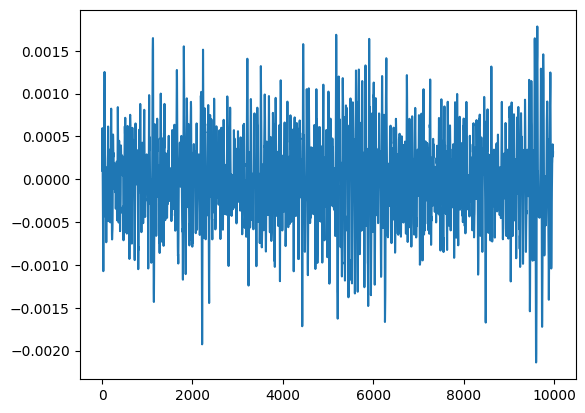

In [39]:
plt.plot(X_amp[1,:])

In [40]:
X_samp = np.array([moving_average(x, 20)**2 for x in X_raw])
X_test_samp = np.array([moving_average(x, 20)**2 for x in X_test_raw])

X_samp.shape


(57, 9982)

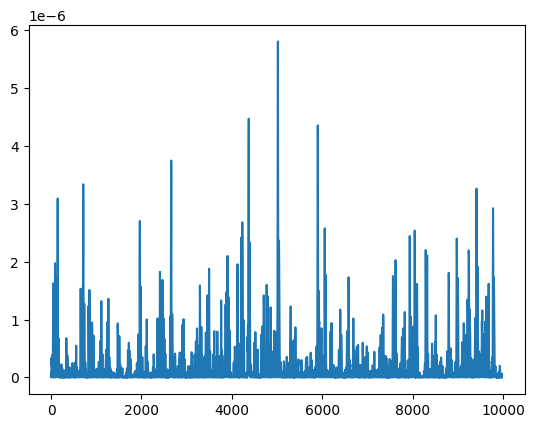

In [41]:
plt.plot(X_samp[-1,:])


In [42]:
from sklearn.decomposition import PCA

n_components = 10
pca = PCA(n_components=n_components)

X_samp_pca = pca.fit_transform(X_samp)
X_test_samp_pca = pca.transform(X_test_samp)

X_samp_pca.shape


(57, 10)

In [53]:
X = X_samp
Y = np.array(Y)
X_test = X_test_samp
Y_test = np.array(Y_test)

(X.shape, Y.shape, X_test.shape, Y_test.shape)


((57, 9982), (57, 2), (6, 9982), (6, 2))

In [54]:
# Define the CNN model
model = Sequential([
    Input((9982,)),
    # Dropout(0.2),
    # GaussianNoise(1e-5),
    Dense(16, activation='gelu'),
    Dense(16, activation='gelu'),
    # Dense(3, activation='gelu'),
    Dense(2, activation='softmax')  # Output layer with softmax for probability output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(X, Y, epochs=128, batch_size=16, validation_data=(X_test, Y_test), verbose=2)

loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/128
4/4 - 2s - 556ms/step - binary_accuracy: 0.5175 - loss: 0.6931 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/128
4/4 - 0s - 13ms/step - binary_accuracy: 0.5263 - loss: 0.6930 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/128
4/4 - 0s - 12ms/step - binary_accuracy: 0.5263 - loss: 0.6930 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/128
4/4 - 0s - 13ms/step - binary_accuracy: 0.5263 - loss: 0.6929 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/128
4/4 - 0s - 14ms/step - binary_accuracy: 0.5263 - loss: 0.6927 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/128
4/4 - 0s - 13ms/step - binary_accuracy: 0.5263 - loss: 0.6927 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/128
4/4 - 0s - 13ms/step - binary_accuracy: 0.5263 - loss: 0.6928 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/128
4/4 - 0s - 13ms/step - binary_accuracy: 0.5263 - loss: 0.6926 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 9/128
4/4

In [55]:
loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Train Loss: 0.6917567849159241
Train Accuracy: 52.63%

Test Loss: 0.6943978667259216
Test Accuracy: 50.00%


Com isso podemos ver como a análise do sinal por si só possui algum tipo de informação que é perdida quando tiramos o quadrado do sinal. Vamos analisar se com uma média corrente de janela maior ainda teremos uma boa performance com a primeira técnica.

In [56]:
X_amp = np.array([moving_average(x, 200) for x in X_raw])
X_test_amp = np.array([moving_average(x, 200) for x in X_test_raw])

X_amp.shape

sample_count = len(X_amp[0])
X = np.array(X_amp).reshape(-1, sample_count)
Y = np.array(Y)
X_test = np.array(X_test_amp).reshape(-1, sample_count)
Y_test = np.array(Y_test)

(X.shape, Y.shape, X_test.shape, Y_test.shape)


((57, 9802), (57, 2), (6, 9802), (6, 2))

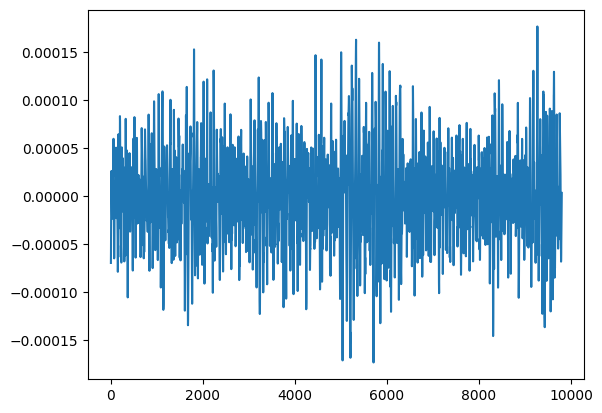

In [57]:
plt.plot(X_amp[1,:])

In [64]:
# Define the CNN model
model = Sequential([
    Input((sample_count,)),
    Dropout(0.99),
    GaussianNoise(1e-5),
    Dense(1, activation='gelu'),
    # Dense(2, activation='gelu'),
    Dense(2, activation='softmax')  # Output layer with softmax for probability output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(X, Y, epochs=2000, batch_size=32, validation_data=(X_test, Y_test), verbose=2)

loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/2000
2/2 - 4s - 2s/step - binary_accuracy: 0.4561 - loss: 0.6932 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/2000
2/2 - 0s - 22ms/step - binary_accuracy: 0.5263 - loss: 0.6931 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/2000
2/2 - 0s - 22ms/step - binary_accuracy: 0.5263 - loss: 0.6931 - val_binary_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/2000
2/2 - 0s - 25ms/step - binary_accuracy: 0.5263 - loss: 0.6931 - val_binary_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/2000
2/2 - 0s - 23ms/step - binary_accuracy: 0.5263 - loss: 0.6930 - val_binary_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/2000
2/2 - 0s - 24ms/step - binary_accuracy: 0.5263 - loss: 0.6930 - val_binary_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/2000
2/2 - 0s - 22ms/step - binary_accuracy: 0.5263 - loss: 0.6930 - val_binary_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/2000
2/2 - 0s - 24ms/step - binary_accuracy: 0.5263 - loss: 0.6930 - val_binary_accuracy: 0.5000 - val_loss: 0.6931
Epoch 9/20

In [60]:
loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Train Loss: 0.6884276270866394
Train Accuracy: 52.63%

Test Loss: 0.6909772753715515
Test Accuracy: 50.00%


Percebemos que ainda é possível aprender a classificar os dados, mas dado que é necessário muito mais tempo para ajustar o modelo aos dados, concluímos que estes dados são menos representativos.

# Dados crus sem pré-processamento

Dadas nosas conclusões anteriores, vamos tentar o treinamento com os dados crus sem média móvel.

In [66]:
X_amp = np.array(X_raw)
X_test_amp = np.array(X_test_raw)

X_amp.shape

sample_count = len(X_amp[0])
X = np.array(X_amp).reshape(-1, sample_count)
Y = np.array(Y)
X_test = np.array(X_test_amp).reshape(-1, sample_count)
Y_test = np.array(Y_test)

(X.shape, Y.shape, X_test.shape, Y_test.shape)


((57, 10001), (57, 2), (6, 10001), (6, 2))

In [67]:
# Define the CNN model
model = Sequential([
    Input((sample_count,)),
    Dropout(0.8),
    GaussianNoise(1e-5),
    # Dense(1, activation='gelu'),
    # Dense(2, activation='gelu'),
    Dense(2, activation='softmax')  # Output layer with softmax for probability output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(X, Y, epochs=50, batch_size=16, validation_data=(X_test, Y_test), verbose=2)

loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/50
4/4 - 3s - 871ms/step - binary_accuracy: 0.7018 - loss: 0.6922 - val_binary_accuracy: 1.0000 - val_loss: 0.6902
Epoch 2/50
4/4 - 0s - 11ms/step - binary_accuracy: 1.0000 - loss: 0.6892 - val_binary_accuracy: 1.0000 - val_loss: 0.6873
Epoch 3/50
4/4 - 0s - 11ms/step - binary_accuracy: 1.0000 - loss: 0.6862 - val_binary_accuracy: 1.0000 - val_loss: 0.6846
Epoch 4/50
4/4 - 0s - 11ms/step - binary_accuracy: 1.0000 - loss: 0.6835 - val_binary_accuracy: 1.0000 - val_loss: 0.6818
Epoch 5/50
4/4 - 0s - 12ms/step - binary_accuracy: 1.0000 - loss: 0.6809 - val_binary_accuracy: 1.0000 - val_loss: 0.6791
Epoch 6/50
4/4 - 0s - 12ms/step - binary_accuracy: 1.0000 - loss: 0.6776 - val_binary_accuracy: 1.0000 - val_loss: 0.6763
Epoch 7/50
4/4 - 0s - 12ms/step - binary_accuracy: 1.0000 - loss: 0.6749 - val_binary_accuracy: 1.0000 - val_loss: 0.6737
Epoch 8/50
4/4 - 0s - 12ms/step - binary_accuracy: 1.0000 - loss: 0.6722 - val_binary_accuracy: 1.0000 - val_loss: 0.6710
Epoch 9/50
4/4 - 0s - 1

In [68]:
loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Train Loss: 0.5662996768951416
Train Accuracy: 100.00%

Test Loss: 0.5695392489433289
Test Accuracy: 100.00%


Podemos ver que comparando os modelos com e sem média móvel, sem a média temos um ajuste quase que instantâneo. Com isso, entendemos que a média corrente "apaga" dados muito representativos.

In [69]:
n_components = 6
pca = PCA(n_components=n_components)

X_amp_pca = pca.fit_transform(X_amp)
X_test_amp_pca = pca.transform(X_test_amp)

X = X_amp_pca
Y = np.array(Y)
X_test = X_test_amp_pca
Y_test = np.array(Y_test)

print(X.shape, Y.shape, X_test.shape, Y_test.shape)

model = Sequential([
    Input((n_components,)),
    Dropout(0.01),
    GaussianNoise(1e-6),
    # Dense(1, activation='gelu'),
    # Dense(2, activation='gelu'),
    Dense(2, activation='softmax')  # Output layer with softmax for probability output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(X, Y, epochs=1000, batch_size=16, validation_data=(X_test, Y_test), verbose=2)

loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


(57, 6) (57, 2) (6, 6) (6, 2)
Epoch 1/1000
4/4 - 2s - 622ms/step - binary_accuracy: 0.6491 - loss: 0.6832 - val_binary_accuracy: 0.6667 - val_loss: 0.6782
Epoch 2/1000
4/4 - 0s - 9ms/step - binary_accuracy: 0.6667 - loss: 0.6825 - val_binary_accuracy: 0.6667 - val_loss: 0.6781
Epoch 3/1000
4/4 - 0s - 9ms/step - binary_accuracy: 0.6667 - loss: 0.6824 - val_binary_accuracy: 0.6667 - val_loss: 0.6781
Epoch 4/1000
4/4 - 0s - 10ms/step - binary_accuracy: 0.7018 - loss: 0.6823 - val_binary_accuracy: 0.6667 - val_loss: 0.6780
Epoch 5/1000
4/4 - 0s - 10ms/step - binary_accuracy: 0.7193 - loss: 0.6822 - val_binary_accuracy: 0.6667 - val_loss: 0.6779
Epoch 6/1000
4/4 - 0s - 9ms/step - binary_accuracy: 0.7544 - loss: 0.6823 - val_binary_accuracy: 0.6667 - val_loss: 0.6778
Epoch 7/1000
4/4 - 0s - 10ms/step - binary_accuracy: 0.7544 - loss: 0.6819 - val_binary_accuracy: 0.6667 - val_loss: 0.6778
Epoch 8/1000
4/4 - 0s - 10ms/step - binary_accuracy: 0.7544 - loss: 0.6819 - val_binary_accuracy: 0.8333

In [70]:
loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Train Loss: 0.586422860622406
Train Accuracy: 84.21%

Test Loss: 0.6063379645347595
Test Accuracy: 83.33%


In [73]:
model = Sequential([
    Input((n_components,)),
    Dropout(0.5),
    GaussianNoise(1e-5),
    # Dense(1, activation='gelu'),
    Dense(2, activation='gelu'),
    GaussianNoise(1e-5),
    Dense(2, activation='softmax')  # Output layer with softmax for probability output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(X, Y, epochs=300, batch_size=16, validation_data=(X_test, Y_test), verbose=2)

loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/300
4/4 - 4s - 923ms/step - binary_accuracy: 0.5088 - loss: 0.6917 - val_binary_accuracy: 0.5000 - val_loss: 0.6920
Epoch 2/300
4/4 - 0s - 17ms/step - binary_accuracy: 0.5614 - loss: 0.6912 - val_binary_accuracy: 0.6667 - val_loss: 0.6920
Epoch 3/300
4/4 - 0s - 11ms/step - binary_accuracy: 0.5789 - loss: 0.6921 - val_binary_accuracy: 0.6667 - val_loss: 0.6919
Epoch 4/300
4/4 - 0s - 14ms/step - binary_accuracy: 0.5789 - loss: 0.6919 - val_binary_accuracy: 0.6667 - val_loss: 0.6919
Epoch 5/300
4/4 - 0s - 15ms/step - binary_accuracy: 0.5614 - loss: 0.6906 - val_binary_accuracy: 0.6667 - val_loss: 0.6918
Epoch 6/300
4/4 - 0s - 13ms/step - binary_accuracy: 0.5439 - loss: 0.6916 - val_binary_accuracy: 0.6667 - val_loss: 0.6918
Epoch 7/300
4/4 - 0s - 14ms/step - binary_accuracy: 0.6140 - loss: 0.6905 - val_binary_accuracy: 0.6667 - val_loss: 0.6917
Epoch 8/300
4/4 - 0s - 14ms/step - binary_accuracy: 0.6316 - loss: 0.6903 - val_binary_accuracy: 0.6667 - val_loss: 0.6917
Epoch 9/300
4/4

In [74]:
loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Train Loss: 0.6073459386825562
Train Accuracy: 94.74%

Test Loss: 0.6315786242485046
Test Accuracy: 83.33%


Vemos acima que com PCA obtemos respostas bem satisfatórias. Com tempo de treinamento suficiente, provavelmente é possível obter acurácia ainda maior.

# Análise das features

Vamos analisar os pares de _features_ escolhidas pelo PCA.

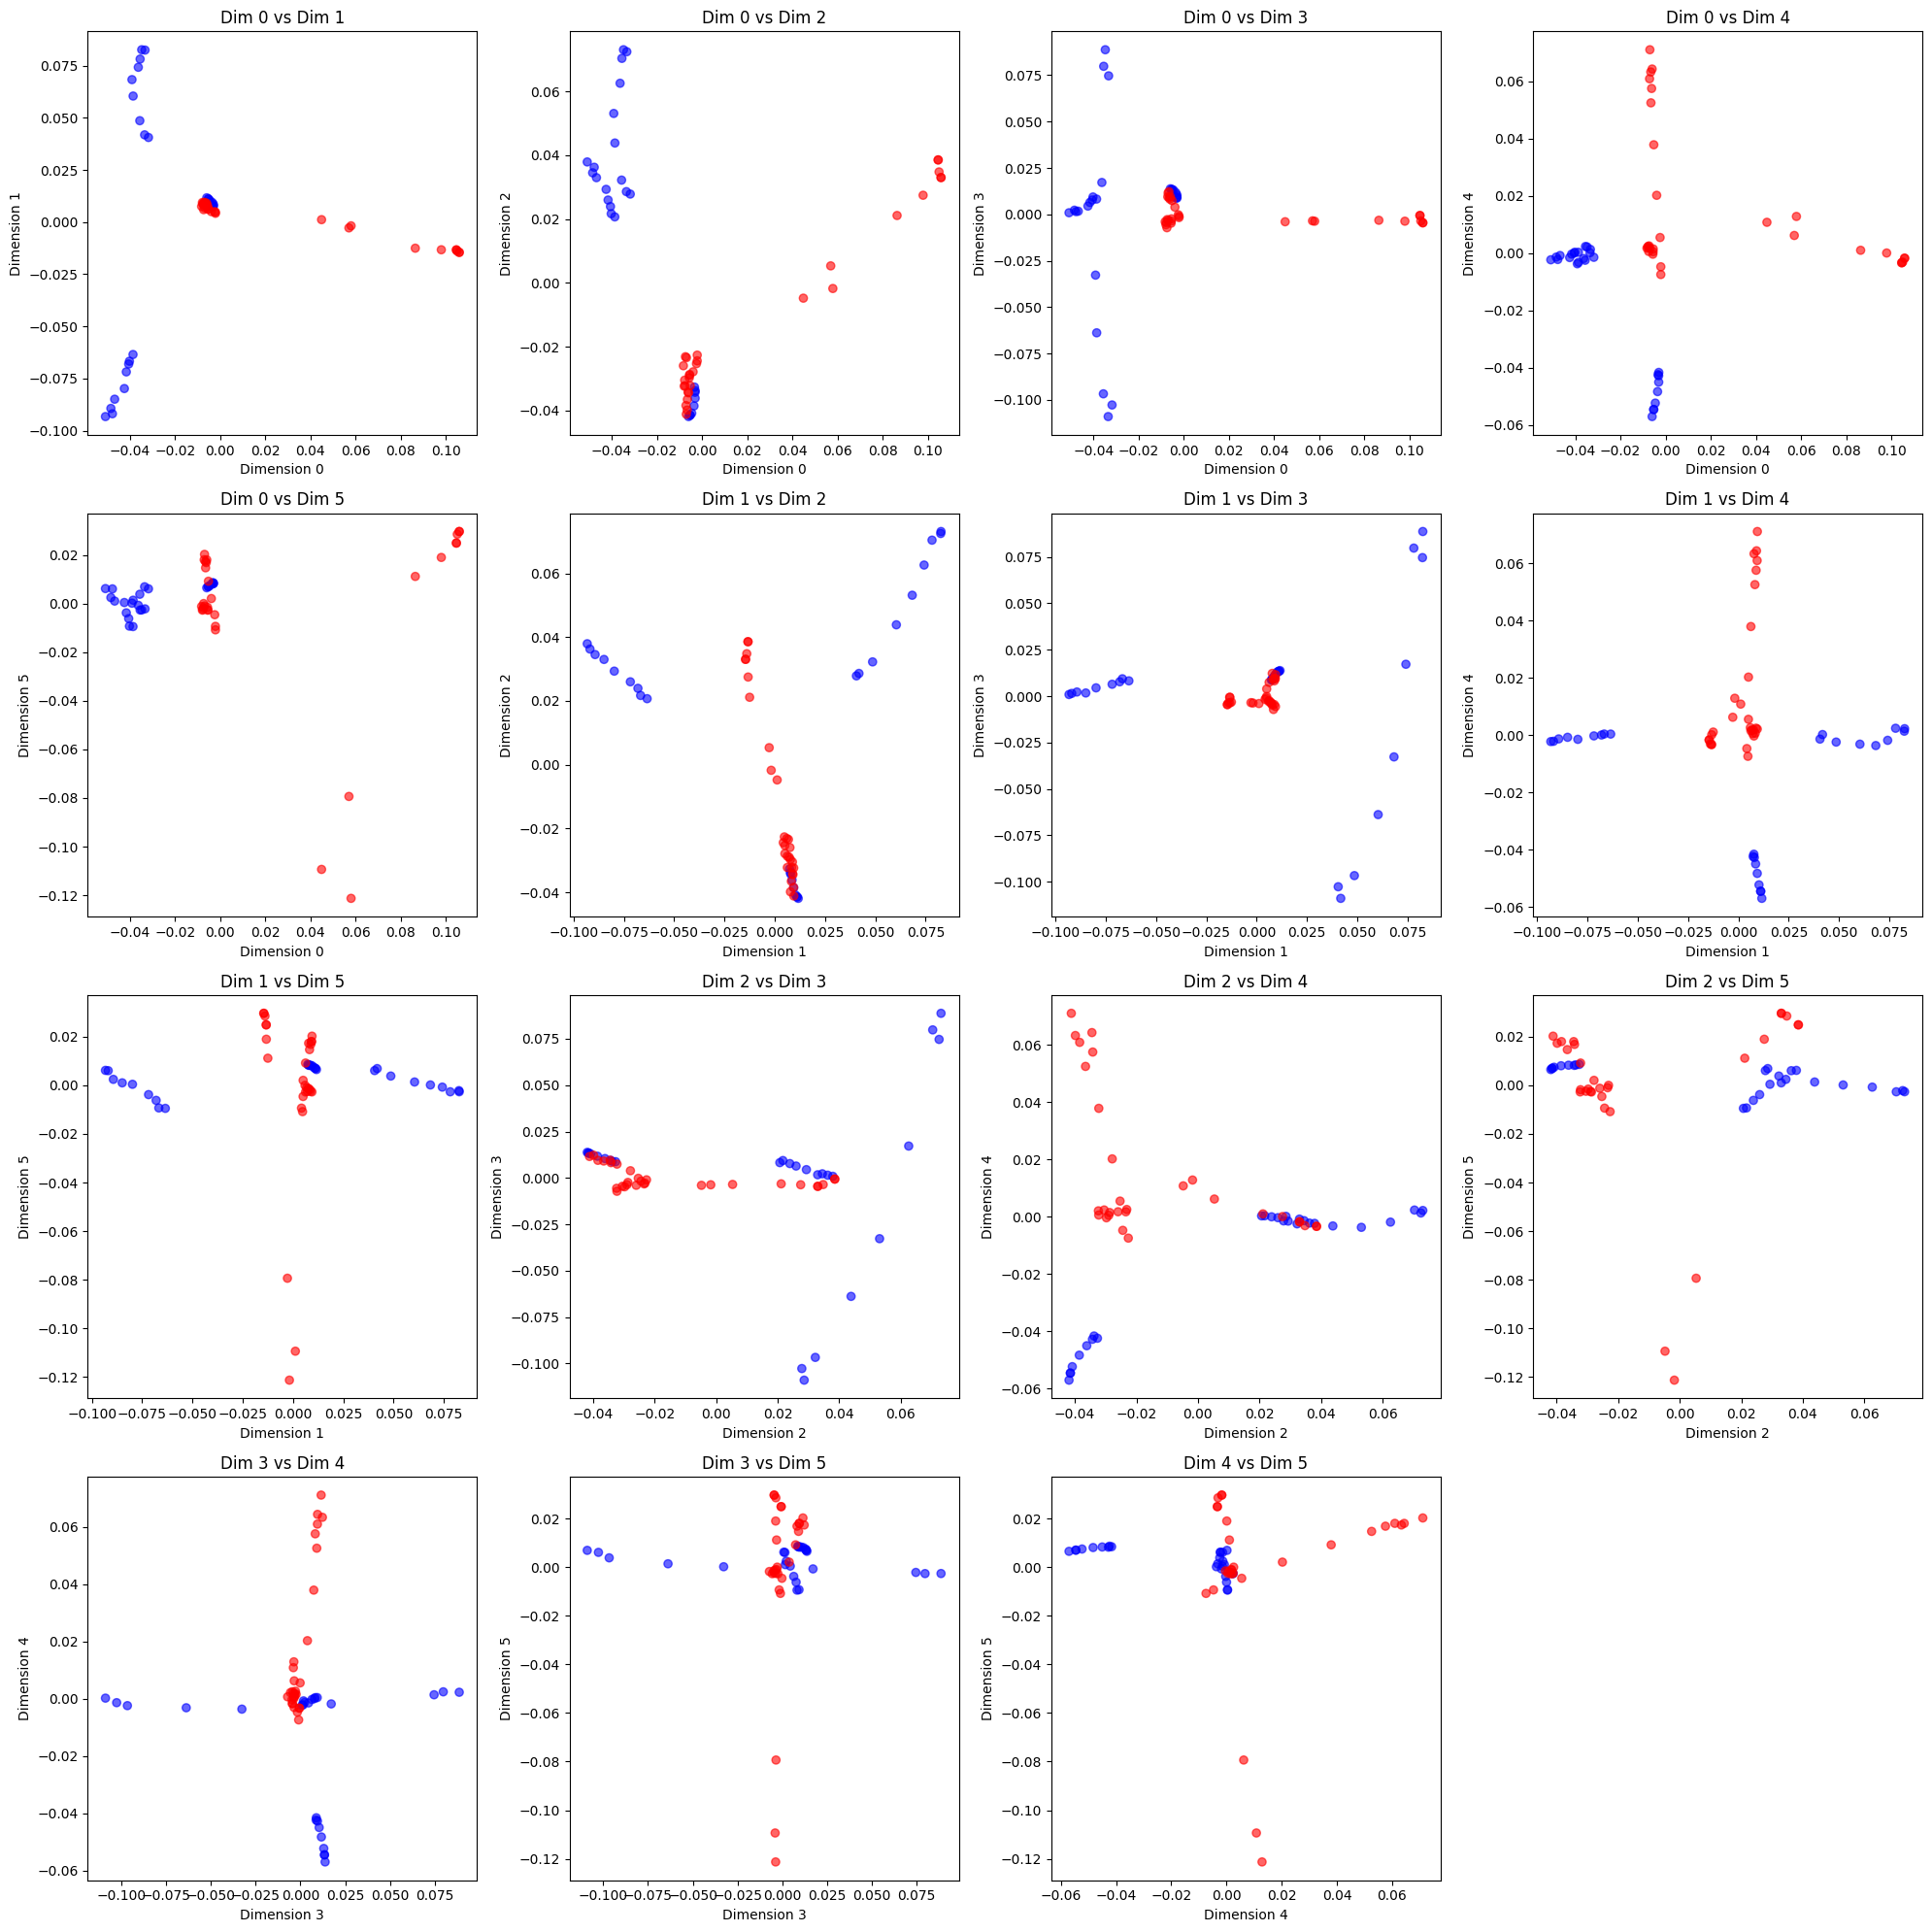

In [75]:
import matplotlib.pyplot as plt
import itertools
import numpy as np

def plot_dimension_pairs(X, Y):
    num_dims = X.shape[1]  # Get the number of dimensions in X
    dimension_pairs = list(itertools.combinations(range(num_dims), 2))  # Generate all 2D pairs
    num_pairs = len(dimension_pairs)

    # Generate color labels based on the Y matrix
    colors = ['blue' if label[0] == 1 else 'red' for label in Y]

    # Determine the grid size for subplots
    n_cols = 4
    n_rows = (num_pairs + n_cols - 1) // n_cols  # Round up to ensure all plots fit

    # Plotting all pairs
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = axes.flatten()

    for idx, (dim1, dim2) in enumerate(dimension_pairs):
        ax = axes[idx]
        ax.scatter(X[:, dim1], X[:, dim2], c=colors, alpha=0.6)
        ax.set_xlabel(f'Dimension {dim1}')
        ax.set_ylabel(f'Dimension {dim2}')
        ax.set_title(f'Dim {dim1} vs Dim {dim2}')

    # Hide any unused subplots
    for i in range(num_pairs, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# Example usage with your matrices
plot_dimension_pairs(X_amp_pca, Y)


Podemos ver nos gráficos acima que nossas features são de fato bem representativas, especialmente considerando o subgrupo (0,1,4).

In [78]:
X = X_amp_pca[:, (0, 1, 4)]
X_test = X_test_amp_pca[:, (0, 1, 4)]

model = Sequential([
    Input((3,)),
    GaussianNoise(1e-6),
    Dense(4, activation='gelu'),
    Dropout(0.3),
    Dense(4, activation='gelu'),
    # GaussianNoise(1e-5),
    Dense(2, activation='softmax')  # Output layer with softmax for probability output
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.fit(X, Y, epochs=512, batch_size=16, validation_data=(X_test, Y_test), verbose=2)

loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Epoch 1/512
4/4 - 4s - 893ms/step - binary_accuracy: 0.6316 - loss: 0.6887 - val_binary_accuracy: 0.6667 - val_loss: 0.6878
Epoch 2/512
4/4 - 0s - 12ms/step - binary_accuracy: 0.5789 - loss: 0.6882 - val_binary_accuracy: 0.8333 - val_loss: 0.6876
Epoch 3/512
4/4 - 0s - 13ms/step - binary_accuracy: 0.7719 - loss: 0.6873 - val_binary_accuracy: 0.8333 - val_loss: 0.6875
Epoch 4/512
4/4 - 0s - 14ms/step - binary_accuracy: 0.7895 - loss: 0.6876 - val_binary_accuracy: 0.8333 - val_loss: 0.6874
Epoch 5/512
4/4 - 0s - 14ms/step - binary_accuracy: 0.7544 - loss: 0.6875 - val_binary_accuracy: 0.8333 - val_loss: 0.6872
Epoch 6/512
4/4 - 0s - 12ms/step - binary_accuracy: 0.7544 - loss: 0.6876 - val_binary_accuracy: 0.8333 - val_loss: 0.6871
Epoch 7/512
4/4 - 0s - 14ms/step - binary_accuracy: 0.7368 - loss: 0.6872 - val_binary_accuracy: 0.6667 - val_loss: 0.6870
Epoch 8/512
4/4 - 0s - 11ms/step - binary_accuracy: 0.7368 - loss: 0.6867 - val_binary_accuracy: 0.6667 - val_loss: 0.6868
Epoch 9/512
4/4

In [79]:
loss, accuracy = model.evaluate(X, Y, verbose=0)
print()
print(f"Train Loss: {loss}")
print(f"Train Accuracy: {accuracy * 100:.2f}%")
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print()
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Train Loss: 0.1685621291399002
Train Accuracy: 100.00%

Test Loss: 0.19473117589950562
Test Accuracy: 100.00%


Com isso, pudemos classificar com perfeita acurácia (dentro do nosso conjunto de dados) todos os pacientes, utilizando apenas 3 features.
Este método utilizando o PCA de um sinal contínuo não é a forma correta de utilizar um PCA, e portanto a seguir buscaremos outras formas de obter features representativas.

# Testes com outros classificadores

In [80]:
def get_average_change(array):
    x = np.linspace(0, 1, len(array)-1)
    arr = (array[1:]-array[:-1]) * x * (1 - x) * 6
    return sum(arr)



def extract_features(arrays):
    features = []
    for array in arrays:
        mean = np.mean(array)
        std = np.std(array)
        min_val = np.min(array)
        max_val = np.max(array)
        median = np.median(array)
        range_val = max_val - min_val
        q1 = np.percentile(array, 25)
        q3 = np.percentile(array, 75)

        half = len(array)//2
        start_median = np.median(array[:half])
        end_median = np.median(array[half:])

        mean_square = np.mean(array ** 2)
        change = get_average_change(array)

        features.append({
            "mean": mean,
            "std": std,
            "min": min_val,
            "max": max_val,
            "median": median,
            "range": range_val,
            "q1": q1,
            "q3": q3,
            "start_median": start_median,
            "end_median": end_median,
            "mean_square": mean_square,
            "avg_change": change,
        })

    features = pl.DataFrame(features)
    return features


Escolhemos diversas features estatísticas, mas experimentalmente determinamos que não eram muito representativas, e portanto, dada a natureza dos sinais para o caso de diabetes, adicionamos as medianas da primeira e segunda metades do sinal, a média do quadrado dos sinais, e também uma diferença média, que calcula todas as variações do sinal, e aplica um peso nulo para os do início e do fim, priorizando assim as diferenças mais centrais, e com sorte, em pacientes diabéticos, esta diferença média será menor que em pacientes saudáveis.

### Creating Feature Set

In [81]:
feature_set = extract_features(X_raw)
feature_set_val = extract_features(X_test_raw)


### Y Flatenning

In [82]:
Y_transformed = np.argmax(Y, axis=1)
Y_test_transformed = np.argmax(Y_test, axis=1)


## Random Forests

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(feature_set, Y)
y_pred = clf.predict(feature_set_val)

print("Accuracy:", accuracy_score(Y_test, y_pred))
print("Classification Report:\n", classification_report(Y_test, y_pred))


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

   micro avg       1.00      1.00      1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6
 samples avg       1.00      1.00      1.00         6



Com Árvores aleatórias obtivemos acurácia perfeita para nossas poucas features.

## KNN

In [84]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(feature_set, Y)
knn_pred = knn_model.predict(feature_set_val)

print("Accuracy:", accuracy_score(Y_test, knn_pred))
print("Classification Report:\n", classification_report(Y_test, knn_pred))


Accuracy: 0.6666666666666666
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.60      1.00      0.75         3

   micro avg       0.67      0.67      0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6
 samples avg       0.67      0.67      0.67         6



## Support Vector Machines (SVM)

In [85]:
from sklearn.svm import SVC
svm_model = SVC(kernel='linear', C=1.0)  # Linear kernel
svm_model.fit(feature_set, Y_transformed)
svm_pred = svm_model.predict(feature_set_val)

print("Accuracy:", accuracy_score(Y_test_transformed, svm_pred))
print("Classification Report:\n", classification_report(Y_test_transformed, svm_pred))


Accuracy: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.50      1.00      0.67         3

    accuracy                           0.50         6
   macro avg       0.25      0.50      0.33         6
weighted avg       0.25      0.50      0.33         6



/home/mvogt/ufsc/infmed/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mvogt/ufsc/infmed/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mvogt/ufsc/infmed/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

### Naive Bayes

In [86]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(feature_set, Y_transformed)
nb_pred = nb_model.predict(feature_set_val)

print("Accuracy:", accuracy_score(Y_test_transformed, nb_pred))
print("Classification Report:\n", classification_report(Y_test_transformed, nb_pred))


Accuracy: 0.6666666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.67      0.67      0.67         3

    accuracy                           0.67         6
   macro avg       0.67      0.67      0.67         6
weighted avg       0.67      0.67      0.67         6



Com esses estudos finalizados, concluímos que os melhores métodos para este caso de estudo, com nossas features escolhidas, são:
- Árvores Aleatórias para as features escolhidas à mão
- Rede Neural para o PCA do sinal no tempo
- Rede Neural para o sinal no tempo

Com todos essas soluções listadas, temos acurácia perfeita na classificação da saúde dos pacientes.